In [1]:
import torch
import torchvision
import sys
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt
import higra as hg
import time
import numpy as np
import cv2

In [2]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: False


In [3]:
 _start_time = time.time()
f = 'output_grid_0_0.tif'
image = cv2.imread('google_chips/'+f) # Copy the link of your image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

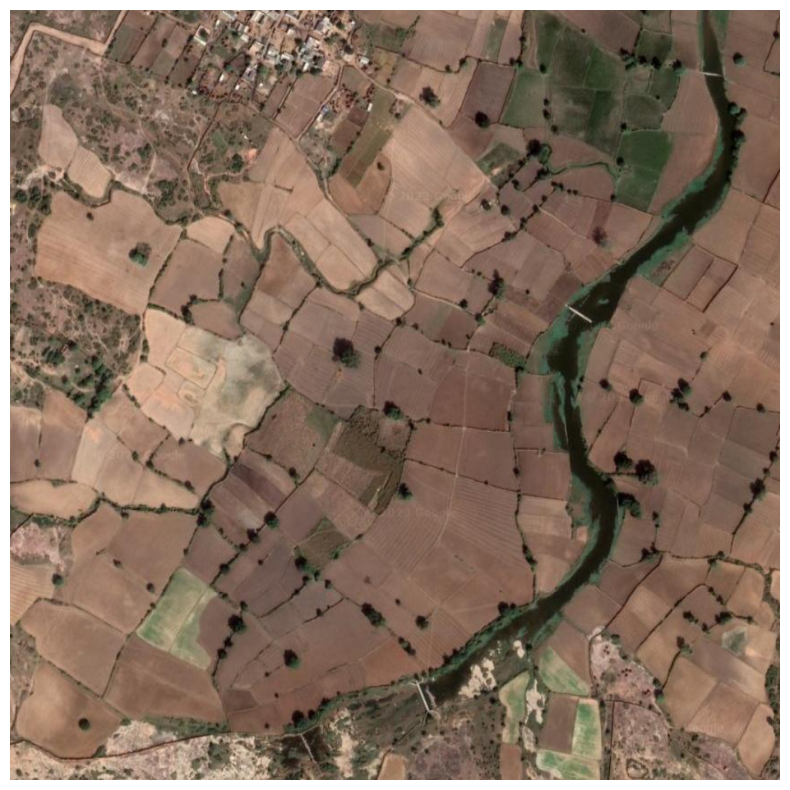

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model = sam, 
                                           points_per_side = 128,
                                           points_per_batch = 64,
                                           pred_iou_thresh = 0.88,
                                           stability_score_thresh = 0.95,
                                           stability_score_offset = 1.0,
                                           box_nms_thresh = 0.7,
                                           crop_n_layers = 0,
                                           crop_nms_thresh = 0.7,
                                           crop_overlap_ratio = 512 / 1500,
                                           crop_n_points_downscale_factor = 1,
                                           point_grids = None,
                                           min_mask_region_area = 0,
                                           output_mode = "binary_mask")

In [6]:
masks = mask_generator.generate(image)
elapsed_time = time.time() - _start_time
print(elapsed_time/60)

45.057565180460614


In [7]:
print(len(masks))
print(masks[0].keys())

375
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

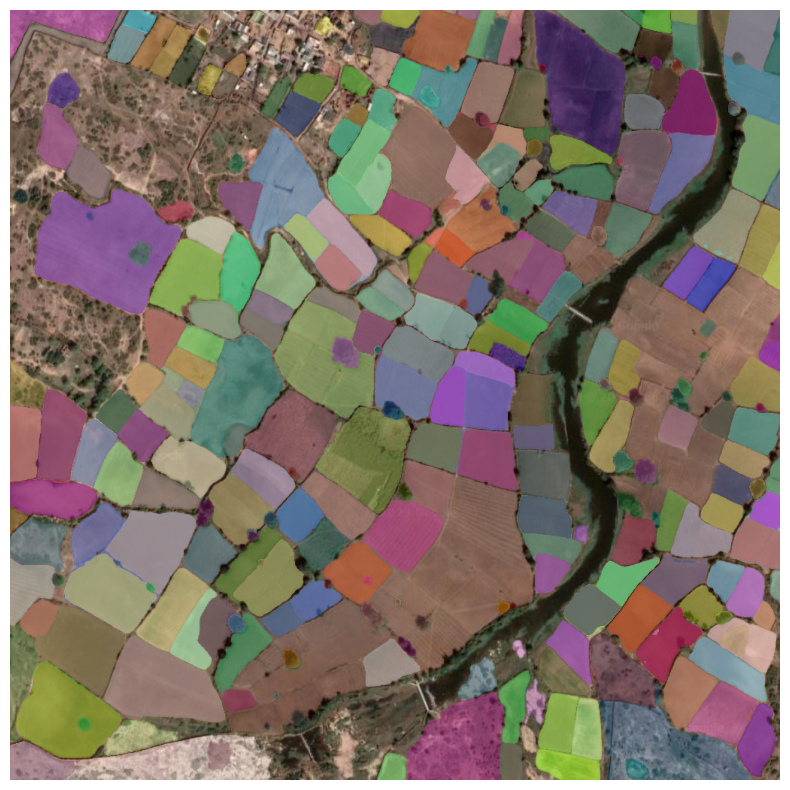

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [10]:
rst = rasterio.open('google_chips/'+f)
meta = rst.meta.copy()
    
meta.update(compress='lzw',dtype='float32', nodata=-10000, count=3)

In [11]:
h, w, _ = image.shape

In [12]:
resulting_mask = np.zeros((h, w), dtype=np.uint8)

In [13]:
resulting_borders = np.zeros((h, w), dtype=np.uint8)

In [14]:
erosion_kernel=(3, 3)
erosion_kernel = np.ones(erosion_kernel, np.uint8)

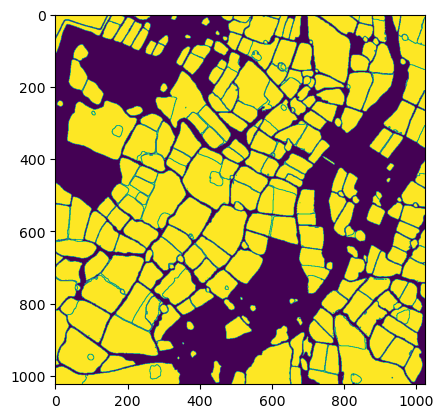

In [15]:
for m in masks:
    mask = (m['segmentation'] > 0).astype(np.uint8)
    resulting_mask += mask

    if erosion_kernel is not None:
        mask_erode = cv2.erode(mask, erosion_kernel, iterations=1)
        mask_erode = (mask_erode > 0).astype(np.uint8)
        edge_mask = mask - mask_erode
        resulting_borders += edge_mask
resulting_mask = (resulting_mask > 0).astype(np.uint8)
resulting_borders = (resulting_borders > 0).astype(np.uint8)
resulting_mask_with_borders = resulting_mask - resulting_borders
final_mask = resulting_mask_with_borders * 255

plt.imshow(final_mask)

In [16]:
meta.update(compress='lzw',dtype=np.uint8,  nodata=0, count=1)
with rasterio.open('out/test.tif', 'w+', **meta) as out:
    out.write_band(1, final_mask.astype(np.uint8))

In [17]:
def boundary(my_array, kernel_size=(3, 3)):
    """
   Return the boundary of image objects.
   Parameters
   ----------
   my_array : 2D array
       Binary array with the image object as 1 and the background as 0.

   kernel_size : list (x, y)
       Kernel dimension to thicken the boundaries; (3,3) by default.

   Returns
   -------
   my_dist
       Normalised distance to the boundary of the image object.
   """
    my_canny = cv2.Canny(my_array.astype(np.uint8), 0, 1)
    my_boundary = cv2.dilate(my_canny.astype(np.uint8),
                             cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size),
                             iterations=1)
    my_boundary = my_boundary.astype(np.float32)
    my_boundary /= 255.

    return my_boundary


def distance_transform(my_array):
    """
    Return the normalised distance (distance transform) to the boundary of an image object.
    Parameters
    ----------
    my_array : 2D array
        Binary array with the image object as 1 and the background as 0.

    Returns
    -------
    my_dist
        Normalised distance to the boundary of the image object.
    """
    ndist = cv2.distanceTransform(my_array.astype(np.uint8),
                                  cv2.DIST_L2, 0)
    ndist = np.around(cv2.normalize(ndist, ndist, 0, 1.0, cv2.NORM_MINMAX), 2)
    ndist[my_array == 0] = 0

    return ndist


def ndistance(my_array):
    """
    Return the normalised distance (distance transform) to the boundary of an image object.
    Parameters
    ----------
    my_array : 2D array
        Binary array with the image object as 1 and the background as 0.

    Returns
    -------
    my_dist
        Normalised distance to the boundary of the image object.
    """
    dst_mrg = my_array.copy().astype(float)
    dst_mrg[:, :] = 0
    # loop through all fields to get the normalised distance
    for i in np.unique(my_array)[1::]:
        r_xtt = my_array.copy()
        r_xtt[r_xtt != i] = 0
        # compute distance transform
        r_dst = distance_transform(r_xtt.astype(int))
        # merge with other fields
        # (we keep the maximum distance for every pixel)
        dst_mrg[:, :] = np.maximum(dst_mrg[:, :], r_dst[:, :])

    return dst_mrg


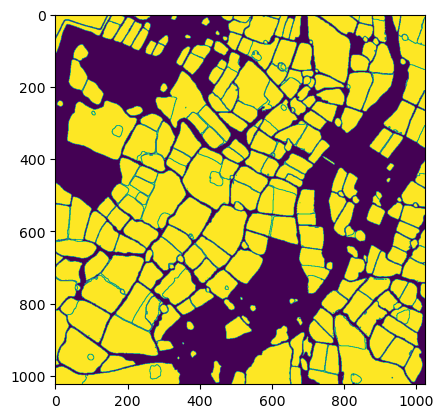

In [18]:
resulting_mask = (resulting_mask > 0).astype(np.float64)
resulting_borders = (resulting_borders > 0).astype(np.float64)
resulting_mask_with_borders = resulting_mask - resulting_borders

r_xtt_mrg = resulting_mask_with_borders.copy()
r_xtt_mrg = (r_xtt_mrg > 0).astype(np.float64)
plt.imshow(r_xtt_mrg)

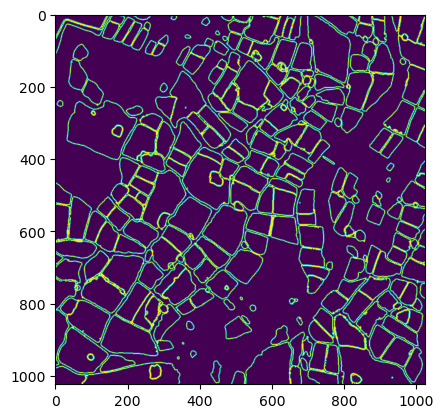

In [19]:
r_bnd_mrg = boundary(resulting_mask_with_borders)
plt.imshow(r_bnd_mrg)

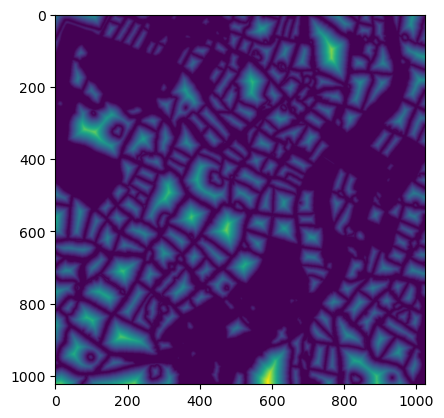

In [20]:
r_dst_mrg = ndistance(resulting_mask_with_borders)
plt.imshow(r_dst_mrg)

In [ ]:
# resulting_mask_with_borders = resulting_mask_with_borders*255
# plt.figure(figsize=(10,10))
# plt.imshow(feature_mask)
# plt.imshow(resulting_borders)
# plt.imshow(resulting_mask_with_borders)
# show_anns(resulting_mask_with_borders)
# plt.axis('off')
# plt.show() 

In [ ]:
feature_mask = np.stack([r_xtt_mrg, r_bnd_mrg, r_dst_mrg],axis=2)
plt.imshow(feature_mask)

In [ ]:
with rasterio.open('out/'+f, 'w+', **meta) as out:
    out.write_band(1, r_xtt_mrg.astype(np.float32))
    out.write_band(2, r_bnd_mrg.astype(np.float32))
    out.write_band(3, r_dst_mrg.astype(np.float32))

In [ ]:
out.close()

In [ ]:
def InstSegm(extent: np.ndarray, boundary: np.ndarray, t_ext: float, t_bound: float) -> np.ndarray:
    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)
    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    # input_hws = boundary
    input_hws[ext_binary == 0] = 1
    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(graph, input_hws, hg.WeightFunction.mean)
    tree, altitudes = hg.watershed_hierarchy_by_dynamics(graph, edge_weights)
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(tree, altitudes, threshold=t_bound)
    # TODO: scale down instances and check if no zeros
    instances[ext_binary == 0] = 0
    # mask = instances.astype(np.uint8)
    # mask[ext_binary != 0] = 1
    return instances.astype(np.int32)


In [ ]:
with rasterio.open('out/'+f) as src:
    img = src.read()
    meta = src.meta.copy()
# adjust metadata to allow tiff storage
meta['dtype'] = 'int32'
meta['count'] = 1


In [ ]:
segmented_image = InstSegm(img[0], img[1], t_ext=0.9, t_bound=0.1)
out_filename = 'out/higra/'+f
with rasterio.open(out_filename, mode='w', **meta) as dataset:
    dataset.write(segmented_image, 1)

In [ ]:
plt.imshow(segmented_image)

In [ ]:
plt.imshow(img[1])

In [1]:
import os

In [3]:
os.chdir('africa/higra/')
li = os.listdir()
li

['output_grid_1_5.tif',
 'output_grid_1_6.tif',
 'output_grid_1_7.tif',
 'output_grid_1_8.tif',
 'output_grid_2_5.tif',
 'output_grid_2_6.tif',
 'output_grid_2_7.tif',
 'output_grid_2_8.tif',
 'output_grid_3_5.tif',
 'output_grid_3_6.tif',
 'output_grid_3_7.tif',
 'output_grid_3_8.tif',
 'output_grid_4_5.tif',
 'output_grid_4_6.tif',
 'output_grid_4_7.tif',
 'output_grid_4_8.tif']

In [ ]:
for i in li:
    cmd = ''

In [ ]:
gdal_polygonize.bat C:/Users/raja.sivaranjan/Documents/SAM_tool/africa/higra/output_grid_4_7.tif -b 1 -f "ESRI Shapefile" C:/Users/raja.sivaranjan/Documents/SAM_tool/africa/shp/output_grid_4_7.shp output_grid_4_7 DN